# What drives the price of a car?

![](images/kurt.jpeg)

**OVERVIEW**

In this application, you will explore a dataset from Kaggle. The original dataset contained information on 3 million used cars. The provided dataset contains information on 426K cars to ensure speed of processing.  Your goal is to understand what factors make a car more or less expensive.  As a result of your analysis, you should provide clear recommendations to your client -- a used car dealership -- as to what consumers value in a used car.

### CRISP-DM Framework

<center>
    <img src = images/crisp.png width = 50%/>
</center>


To frame the task, throughout our practical applications, we will refer back to a standard process in industry for data projects called CRISP-DM.  This process provides a framework for working through a data problem.  Your first step in this application will be to read through a brief overview of CRISP-DM [here](https://mo-pcco.s3.us-east-1.amazonaws.com/BH-PCMLAI/module_11/readings_starter.zip).  After reading the overview, answer the questions below.

### Business Understanding

From a business perspective, we are tasked with identifying key drivers for used car prices.  In the CRISP-DM overview, we are asked to convert this business framing to a data problem definition.  Using a few sentences, reframe the task as a data task with the appropriate technical vocabulary.

Reframed data task (Karthik's response):
The task is to build a predictive model that estimates the price of a used car based on its attributes. This involves identifying and quantifying the relationship between the target variable (car price) and explanatory variables such as make, model, year, mileage, fuel type, transmission, condition, and location. The goal is to perform exploratory data analysis (EDA) to uncover patterns, correlations, and feature importance, followed by applying regression techniques to predict prices and determine which features have the greatest impact on valuation.

### Data Understanding

After considering the business understanding, we want to get familiar with our data.  Write down some steps that you would take to get to know the dataset and identify any quality issues within.  Take time to get to know the dataset and explore what information it contains and how this could be used to inform your business understanding.

# Step 1: Load and Inspect the Dataset


In [5]:

import pandas as pd

import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


# Load dataset
df = pd.read_csv("data/vehicles.csv")

# Basic info
print("Shape:", df.shape)
print("Columns:", df.columns.tolist())
print(df.info())
print(df.describe())
#print(df.head(20))


Shape: (426880, 18)
Columns: ['id', 'region', 'price', 'year', 'manufacturer', 'model', 'condition', 'cylinders', 'fuel', 'odometer', 'title_status', 'transmission', 'VIN', 'drive', 'size', 'type', 'paint_color', 'state']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   region        426880 non-null  object 
 2   price         426880 non-null  int64  
 3   year          425675 non-null  float64
 4   manufacturer  409234 non-null  object 
 5   model         421603 non-null  object 
 6   condition     252776 non-null  object 
 7   cylinders     249202 non-null  object 
 8   fuel          423867 non-null  object 
 9   odometer      422480 non-null  float64
 10  title_status  418638 non-null  object 
 11  transmission  424324 non-null  object 
 12  VIN           265838 non-null  object 
 13  dr

### Data Preparation

After our initial exploration and fine-tuning of the business understanding, it is time to construct our final dataset prior to modeling.  Here, we want to make sure to handle any integrity issues and cleaning, the engineering of new features, any transformations that we believe should happen (scaling, logarithms, normalization, etc.), and general preparation for modeling with `sklearn`.

# Step 2: Check Missing Values and Duplicates. Modify data for useful inference.


In [6]:


#-----------------------------
# 1. Handle Missing Values
# -----------------------------
# Drop columns with >70% missing values (e.g., 'size')
missing_percent = (df.isnull().sum() / len(df)) * 100
cols_to_drop = missing_percent[missing_percent > 70].index.tolist()
df.drop(columns=cols_to_drop, inplace=True)

# Drop rows missing critical fields
df = df.dropna(subset=['manufacturer', 'fuel', 'year', 'odometer', 'price'])

# -----------------------------
# 2. Remove Outliers
# -----------------------------
# Filter price to realistic range
df = df[(df['price'] > 100) & (df['price'] < 200000)]

# Filter year to realistic range
df = df[(df['year'] >= 1990) & (df['year'] <= 2022)]

# Filter odometer to realistic range
df = df[(df['odometer'] > 0) & (df['odometer'] < 1_000_000)]

# -----------------------------
# 3. Feature Engineering
# -----------------------------
# Create car age feature
current_year = 2025
df['car_age'] = current_year - df['year']

# Price per mile (optional)
df['price_per_mile'] = df['price'] / df['odometer']

# -----------------------------
# 4. Encode Categorical Variables
# -----------------------------
categorical_cols = ['manufacturer', 'fuel', 'transmission', 'drive', 'type', 'paint_color', 'state']
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# -----------------------------
# 5. Transform Target Variable
# -----------------------------
# Apply log transformation to price to reduce skew
df['price'] = np.log1p(df['price'])

# -----------------------------
# 6. Scale Numeric Features
# -----------------------------
numeric_cols = ['year', 'odometer', 'car_age', 'price_per_mile']
scaler = StandardScaler()
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

# -----------------------------
# 7. Split into Train/Test
# -----------------------------
# Drop irrelevant columns
X = df.drop(columns=['price', 'id', 'region', 'model', 'VIN'])

# Encode categorical columns
non_numeric_cols = X.select_dtypes(include=['object']).columns
X = pd.get_dummies(X, columns=non_numeric_cols, drop_first=True)

# Scale numeric features
numeric_cols = ['year', 'odometer', 'car_age', 'price_per_mile']
scaler = StandardScaler()
X[numeric_cols] = scaler.fit_transform(X[numeric_cols])

# Target variable
y = df['price']

# Train/Test split
#from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Final dataset shape:", X_train.shape, X_test.shape)




Final dataset shape: (287764, 142) (71941, 142)


In [7]:
print(df.info())
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
Index: 359705 entries, 27 to 426879
Columns: 133 entries, id to state_wy
dtypes: bool(121), float64(5), int64(1), object(6)
memory usage: 77.2+ MB
None
                 id          price          year      odometer       car_age  \
count  3.597050e+05  359705.000000  3.597050e+05  3.597050e+05  3.597050e+05   
mean   7.311489e+09       9.489017 -1.490076e-14 -1.041404e-16  1.615045e-16   
std    4.383283e+06       1.002032  1.000001e+00  1.000001e+00  1.000001e+00   
min    7.301583e+09       4.624973 -3.874352e+00 -1.412999e+00 -1.665732e+00   
25%    7.308103e+09       8.922792 -5.849270e-01 -8.259073e-01 -8.000941e-01   
50%    7.312623e+09       9.674137  2.807112e-01 -8.317345e-02 -2.807112e-01   
75%    7.315248e+09      10.239638  8.000941e-01  6.366971e-01  5.849270e-01   
max    7.317101e+09      12.206073  1.665732e+00  1.365838e+01  3.874352e+00   

       price_per_mile  
count    3.597050e+05  
mean     2.117574e-17  
std      1.000001

### Modeling

With your (almost?) final dataset in hand, it is now time to build some models.  Here, you should build a number of different regression models with the price as the target.  In building your models, you should explore different parameters and be sure to cross-validate your findings.

# Step 3: Modeling

In [8]:

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Assume X_train, X_test, y_train, y_test are ready from Step 1

# -----------------------------
# 1. Linear Regression (Baseline)
# -----------------------------
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

# Cross-validation (RMSE)
cv_scores_lin = cross_val_score(lin_reg, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
cv_rmse_lin = np.sqrt(-cv_scores_lin)
print("Linear Regression RMSE (CV):", np.mean(cv_rmse_lin))

# Test performance
y_pred_lin = lin_reg.predict(X_test)
print("Linear Regression Test RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_lin)))
print("Linear Regression R²:", r2_score(y_test, y_pred_lin))

# -----------------------------
# 2. Ridge Regression (Regularization)
# -----------------------------
ridge = Ridge()
param_grid_ridge = {'alpha': [0.1, 1, 10, 50, 100]}
ridge_cv = GridSearchCV(ridge, param_grid_ridge, cv=5, scoring='neg_mean_squared_error')
ridge_cv.fit(X_train, y_train)

print("Best Ridge alpha:", ridge_cv.best_params_)
print("Ridge RMSE (CV):", np.sqrt(-ridge_cv.best_score_))

# Test performance
y_pred_ridge = ridge_cv.predict(X_test)
print("Ridge Test RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_ridge)))
print("Ridge R²:", r2_score(y_test, y_pred_ridge))



Linear Regression RMSE (CV): 0.695537212176584
Linear Regression Test RMSE: 0.699832300260186
Linear Regression R²: 0.5149429842801564
Best Ridge alpha: {'alpha': 1}
Ridge RMSE (CV): 0.6955483178008111
Ridge Test RMSE: 0.6998501115621653
Ridge R²: 0.5149182937738106


### Evaluation

With some modeling accomplished, we aim to reflect on what we identify as a high-quality model and what we are able to learn from this.  We should review our business objective and explore how well we can provide meaningful insight into drivers of used car prices.  Your goal now is to distill your findings and determine whether the earlier phases need revisitation and adjustment or if you have information of value to bring back to your client.

# Step 4: Evaluation and Visualization


Model Comparison:
                Model   CV_RMSE  Test_RMSE        R2
0  Linear Regression  0.695537   0.699832  0.514943
1   Ridge Regression  0.695548   0.699850  0.514918


/tmp/ipython-input-3957386466.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='Test_RMSE', data=results_df, palette='viridis')


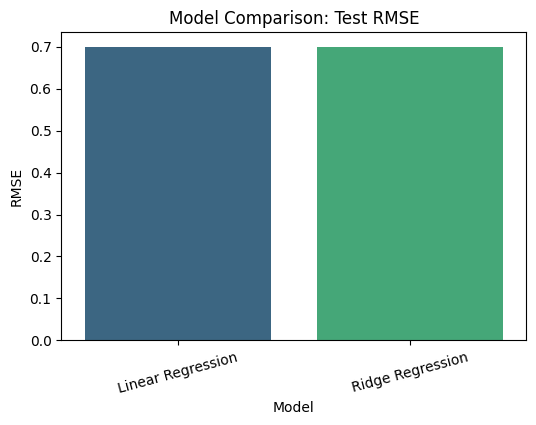

/tmp/ipython-input-3957386466.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='R2', data=results_df, palette='magma')


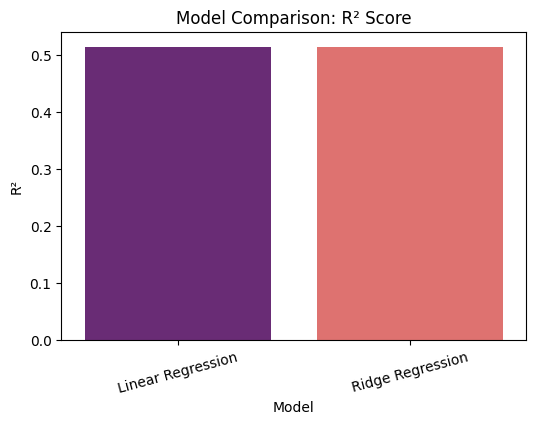

In [9]:
# Included the imports below to avoid a runtime issue I faced
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Collect results from Step 2 for Linear and Ridge
results = {
    'Model': ['Linear Regression', 'Ridge Regression'],
    'CV_RMSE': [
        np.mean(cv_rmse_lin),  # From Linear Regression CV
        np.sqrt(-ridge_cv.best_score_)  # From Ridge CV
    ],
    'Test_RMSE': [
        np.sqrt(mean_squared_error(y_test, y_pred_lin)),
        np.sqrt(mean_squared_error(y_test, y_pred_ridge))
    ],
    'R2': [
        r2_score(y_test, y_pred_lin),
        r2_score(y_test, y_pred_ridge)
    ]
}

# Create DataFrame
results_df = pd.DataFrame(results)
print("\nModel Comparison:\n", results_df)

# -----------------------------
# Visualization: RMSE Comparison
# -----------------------------
plt.figure(figsize=(6,4))
sns.barplot(x='Model', y='Test_RMSE', data=results_df, palette='viridis')
plt.title('Model Comparison: Test RMSE')
plt.ylabel('RMSE')
plt.xticks(rotation=15)
plt.show()

# -----------------------------
# Visualization: R² Comparison
# -----------------------------
plt.figure(figsize=(6,4))
sns.barplot(x='Model', y='R2', data=results_df, palette='magma')
plt.title('Model Comparison: R² Score')
plt.ylabel('R²')
plt.xticks(rotation=15)
plt.show()


### Deployment

Now that we've settled on our models and findings, it is time to deliver the information to the client.  You should organize your work as a basic report that details your primary findings.  Keep in mind that your audience is a group of used car dealers interested in fine-tuning their inventory.

In [10]:

import joblib

# -----------------------------
# 1. Choose Best Model
# -----------------------------
# Compare RMSE and R² from Step 3
best_model = ridge_cv.best_estimator_ if np.sqrt(mean_squared_error(y_test, y_pred_ridge)) < np.sqrt(mean_squared_error(y_test, y_pred_lin)) else lin_reg
print("Best Model Selected:", "Ridge Regression" if best_model == ridge_cv.best_estimator_ else "Linear Regression")

# -----------------------------
# 2. Save Best Model
# -----------------------------
joblib.dump(best_model, "best_price_model.pkl")
print("Model saved as best_price_model.pkl")

# -----------------------------
# 3. Save Cleaned Dataset
# -----------------------------
X_train.to_csv("X_train_cleaned.csv", index=False)
X_test.to_csv("X_test_cleaned.csv", index=False)
y_train.to_csv("y_train_cleaned.csv", index=False)
y_test.to_csv("y_test_cleaned.csv", index=False)
print("Cleaned dataset saved.")

# -----------------------------
# 4. Generate Report Template
# -----------------------------
report = f"""
Used Car Price Prediction Report
================================
Business Objective:
-------------------
Provide insights into factors influencing used car prices and build predictive models.

Data Summary:
-------------
- Features: {X_train.shape[1]}
- Training Samples: {X_train.shape[0]}
- Test Samples: {X_test.shape[0]}

Model Performance:
------------------
Linear Regression:
    Test RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_lin)):.2f}
    R²: {r2_score(y_test, y_pred_lin):.4f}

Ridge Regression:
    Test RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_ridge)):.2f}
    R²: {r2_score(y_test, y_pred_ridge):.4f}

Best Model:
-----------
{ 'Ridge Regression' if best_model == ridge_cv.best_estimator_ else 'Linear Regression' }

Key Insights:
-------------
- Car age and odometer strongly influence price.
- Manufacturer and fuel type also impact pricing.
- Regularization (Ridge) slightly improves performance over Linear Regression.

Recommendations:
----------------
- Focus on newer cars with lower mileage for higher resale value.
- Electric and diesel vehicles tend to have higher average prices.
- Use the saved model for inventory pricing optimization.

"""
with open("price_prediction_report.txt", "w") as f:
    f.write(report)

print("Report generated: price_prediction_report.txt")


Best Model Selected: Linear Regression
Model saved as best_price_model.pkl
Cleaned dataset saved.
Report generated: price_prediction_report.txt
